# Playing with MNIST
We will get to play with the Hello World of datasets, the MNIST digit set.  

Goals:
* Download MNIST Data set
* Binary Classifier
* Performance Measures
    * Cross Validation
    * Confusion Matrix
    * Precision/Recall Stats/Tradeoff
* Multiclass Classifier
* Error Analysis
* Multilabel Classifier
* Multioutput Classifier

## Downloading the Data Set
We split the data into data (X) and label (y) lists.  

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
print(mnist)

X, y = mnist["data"], mnist["target"]

{'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]), 'COL_NAMES': ['label', 'data'], 'DESCR': 'mldata.org dataset: mnist-original'}


To test, the text looks at a random digit, 36000.  We can turn the list of pixel values back into an array by reshaping.  The reshaped array can be plotted to see the original image of the digit.

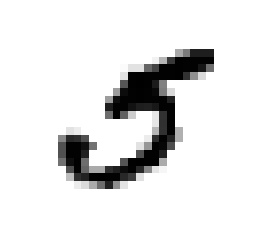

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_digit(digit):
    digit_reshaped = digit.reshape(28,28)
    plt.imshow(digit_reshaped, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()

some_index = 36000
some_digit = X[some_index]
plot_digit(some_digit)

Now we need to split this data set into training and testing sets.  The MNIST set comes presplit, 60k training followed by 10k testing.  We also shuffle the sets.

In [3]:
import numpy as np

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]  

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier
We start with a binary classifier, where we decide if an image has a set property or not.  In this case, our property is if the image is a 5 or not 5.  

Python makes it easy to create a new target.  Now we want the label to be a 1 if the image is a 5, and 0 if not.  

In [4]:
y_train_5 = (y_train == 5) # New Training labels, 1 if 5, 0 if not
y_test_5  = (y_test == 5)  # New labels for the test set

To start, we will try out a **Stochastic Gradient Descent Classifier**.

In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

To test, we can try the model out on the digit we checked before.

In [6]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

Yay!  That works, but lets look at some performance measures.  
## Performance Measures

### Cross Validation
We should check the model by doing a k-folds cross validation.  This will give us an idea of how well the model is doing on its input, and try to measure some kind of overfitting.  

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score( sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy" )

array([ 0.953  ,  0.96595,  0.95765])

This looks good, but is not great when you consider that the data set is skewed.  Since only one tenth of our input is a 5, just guessing not-5 gets a model to 90% accuracy.  So an added 5% isn't great.
 
This also highlights the uselessness of bare accuracy as ameasure of a models efficacy.  We can use other Methods to investigate the actual effectiveness.

### Confusion Matrix
A confusion matrix shows the true and false negatives and positives.  This gives a much better view of the efficacy.  In a perfect model, we would only have true positives and true negatives.  No 5's would be called not 5s and no not-5's would be called 5's.

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53340,  1239],
       [ 1229,  4192]])

This isn't great.  We have 1616 5's that were labeled not-5's, and we have 441 not-5's that were labeled as 5's. To further investigate these values, we can look at Precision and Recal statititics.  These encode the rates of false positives and negatives.  

### Precision and Recall

**Precision** is the rate of true positives to total positives (TP+FP).  How well we avoid false positives.

**Recall** is the rate of true positives to the total number of actual positives, regardless of how they were classified (TP+FN).  How well we avoid false negatives.

For both values, we would like numbers very close to 1.  We can combine both measures into one metric, the F_1 score.  The closer a models precision and recall values are, the closer f1 will be to 1. 

Later we will see that this highlights a tradeoff between these values.  Working to increase one typically decreases the other.  Implying there is an optimal location to selec depending on your problem.  

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

p_score, r_score = precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)
f1_score = f1_score(y_train_5, y_train_pred)
print( 'prec: {:f} \nrecall: {:f} \nf1: {:f}'.format( p_score, r_score, f1_score ) )

prec: 0.771865 
recall: 0.773289 
f1: 0.772576


### Takeaway
It seems that for each type of classifier or regression we will have a selection of measures to use that fit the classifier or regression.  The job will be to learn what type of classifier to use, and then what type of performance measure to use.  The book also mentions the following topics, specific especially to binary classifiers:

* Precision/Recall Curve - Plot the effect of changing the threshold value for the models decision function.  Increasing threshold increases precision, but lowers recall.  
* Receiver Operating Characteristic Curve - Specific to binary classifiers.  true positive rate vs false positive rate.  Plotted over a range of threshol values.  Area under the curve == measure of effectiveness.  1 = perfect.

## Multiclass Classification
### Using Binary Classifiers
There are many ways to use multiple binary classifiers to create a multi-class classifier.  
* One-vs-All - Create a clasifier for each feature, then output the label for the classifier that returns the highest decision score.
* One-vs-One - Create a classifier for each pair of features.  Then output the label for the feature that wins the most 'duels'. Requires O(n^2) classifiers, but each uses only a fraction of the training data.

SKLearn automatically detects when a label set has multiple classes, and defaults to running a OvA classifier.

In [10]:
# Using our classifier from before, but now with the full label set.
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

Note that the classifier now has 10 individual binary clasifiers under the hood.  We can even see the individual classifiers decision scores.

In [11]:
some_scores = sgd_clf.decision_function([some_digit])
some_scores

array([[-234050.49270136, -434093.58331191, -367465.8454057 ,
        -339818.75278841, -261896.88948718,   24082.83999573,
        -777017.75478323, -266973.07685643, -658737.59554043,
        -580588.55824341]])

We can test the error.

In [12]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87202559,  0.86414321,  0.79366905])

Nice!  Random classifiers would have accuracies of about 10%.  So this is a good sign.  But we should also check the confusion matrix.  This could give us insight into how we could imrpove the model further. 

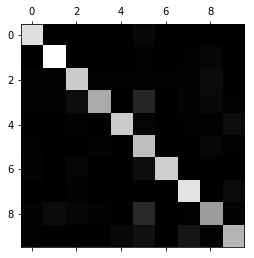

In [13]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The darker an area, the lower the value of that element in the confusion matrix.  So the very light values along the diagonal correspond to the fact that our model is doing well at giving digits the right label.  

We can get more information by looking at just the errors.

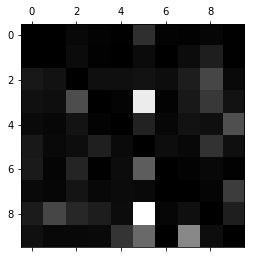

In [14]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # Get the number of each digit in the set by summing over rows
norm_conf_mx = conf_mx/row_sums  # Normalize the old matrix by dividing by the number of that digit.  

np.fill_diagonal(norm_conf_mx, 0) # This fills the diagonals with 0's, cause we dont care about the accurate results
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

The brighter the cell, the more often that error occurs.  We can see that the row for 8 is particularly bright, implying that the model often misclassifies 8's.

We can get an idea of what the errors actually look like by plotting examples of confused labels.

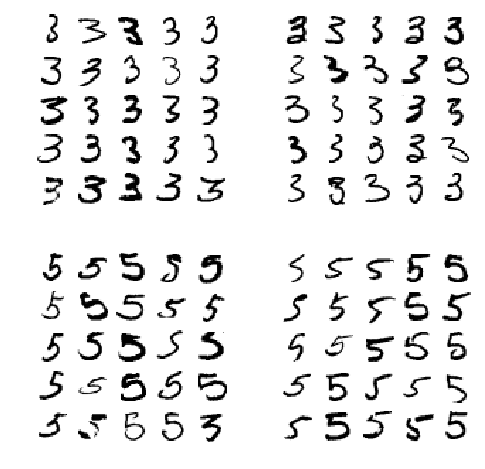

In [15]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
            
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The first column shows images that had an orignal label of 3, the second column had a label of 5.  The first row shows images classified by the model as 3, and the second 5.  So our true positives are the main diagonal, and the off diagonal shows the misclasifications. 

### Multilabel Classification
We can use classifiers that output more than one label.  In the previous techniques, we used multiple binary classifiers to get a measure of how likely a certain label pertained to the input. We then selected the 'best' of these values.

In multilabel, the outputs can be categories that overlap, were above we were looking for a single best label out of a set, multilabe classification can output many labels that all pertain to the input.  

For example, we could create test sets where we are looking to decide if an input is a large number (7,8,9) or an odd number.  So there are cases where neither label is appropriate (2,4), cases where only one is (1, 8), and cases where both are correct (7, 9). 

In this example, we use a K-Nearest-Neighbors classifier.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd   = (y_train % 2 == 1)
y_train_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit( X_train, y_train_multilabel )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

To test this out, we can give it our ol' sample digit.

In [17]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

The vector output says that the label "large" doesnt apply, and the label "odd" does.  Correct!

#### Evaluating Model
We can evaluate the model by computing the average of all F1 scores for KFolds across all labels.

In [18]:
# y_train_knn_pred = cross_val_predict( knn_clf, X_train, y_train )
# f1_score(y_train, y_train_knn_pred, average="macro")

### MultiOutput Classifier
We can also train classifiers that produce more than one label, and this label can have a range of values.  This is a generalization of the multilabel classifier, where the labels had binary values.  

To see why this is useful, we can consider an image.  This is just a list of pixels, or labels, each with a value, the grayscale value.  So we could conceive of a classifier that takes an image as an input, and outputs an image as a set of labels for pixels.  

As an example, we will create a set of 'noisy' images by adding small random amounts to the input images, and using the originals as a target set.

Then, the classifier will, hopefully, be able to take a noisy image as an input, and output a cleaned version.

We then use another knn classifier to build the model.

In [26]:


noise = np.random.randint(0,100, (len(X_train), 784))
X_train_noise = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_noise  = X_test + noise

y_train_noise = X_train
y_test_noise  = X_test
# So now the X's are the noisy images, and the y's are the original, non noisy images.

knn_clf.fit( X_train_noise, y_train_noise )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Now we test it out!

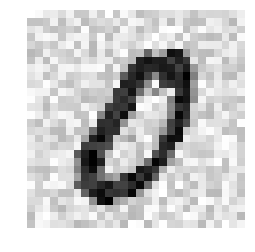

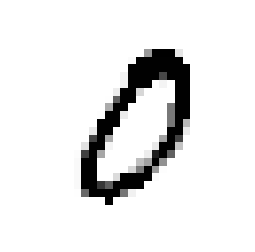

In [28]:
some_index = 723
dirty_digit = X_test_noise[some_index]
clean_digit = knn_clf.predict([dirty_digit])
plot_digit(dirty_digit)
plot_digit(clean_digit)

Holyfuckballs.  This thing works!!!!  We should evaluate, as per our ML checklist.  